# Belgian economic production model

## Data extraction and conversion

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### NACE Conversion matrices

https://www.nbb.be/doc/dq/e/method/b_necd10.pdf

#### NACE 21 to NACE 10

National-level production model so U (extraterritorial activities must be removed).

In [3]:
columns = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T']
index = ['A','B, C, D, E','F','G-H-I','J','K','L','M-N','O, P, Q','R, S, T']

In [4]:
NACE_21to10_mat = np.zeros([10,20])
NACE_21to10_mat[0,0] = 1
NACE_21to10_mat[1,1:5] = 1
NACE_21to10_mat[2,5] = 1
NACE_21to10_mat[3,6:9] = 1
NACE_21to10_mat[4,9] = 1
NACE_21to10_mat[5,10] = 1
NACE_21to10_mat[6,11] = 1
NACE_21to10_mat[7,12:14] = 1
NACE_21to10_mat[8,14:17] = 1
NACE_21to10_mat[9,17:20] = 1

In [5]:
NACE21to10 = pd.DataFrame(data=NACE_21to10_mat,columns=columns,index=index)
NACE21to10.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"B, C, D, E",0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G-H-I,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### NACE 38 to NACE 21

National-level production model so U (extraterritorial activities must be removed).

In [6]:
columns = ['AA','BB','CA','CB','CC','CD','CE','CF','CG','CH','CI','CJ','CK','CL','CM','DD','EE','FF','GG','HH','II','JA','JB','JC','KK','LL','MA','MB','MC','NN','OO','PP','QA','QB','RR','SS','TT']
index = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T']

In [7]:
NACE_38to21_mat = np.zeros([20,37])
NACE_38to21_mat[0,0] = 1
NACE_38to21_mat[1,1] = 1
NACE_38to21_mat[2,2:15] = 1
NACE_38to21_mat[3,15] = 1
NACE_38to21_mat[4,16] = 1
NACE_38to21_mat[5,17] = 1
NACE_38to21_mat[6,18] = 1
NACE_38to21_mat[7,19] = 1
NACE_38to21_mat[8,20] = 1
NACE_38to21_mat[9,21:24] = 1
NACE_38to21_mat[10,24] = 1
NACE_38to21_mat[11,25] = 1
NACE_38to21_mat[12,26:29] = 1
NACE_38to21_mat[13,29] = 1
NACE_38to21_mat[14,30] = 1
NACE_38to21_mat[15,31] = 1
NACE_38to21_mat[16,32:34] = 1
NACE_38to21_mat[17,34] = 1
NACE_38to21_mat[18,35] = 1
NACE_38to21_mat[19,36] = 1

In [8]:
NACE38to21 = pd.DataFrame(data=NACE_38to21_mat,columns=columns,index=index)
NACE38to21.head()

,AA,BB,CA,CB,CC,CD,CE,CF,CG,CH,...,MB,MC,NN,OO,PP,QA,QB,RR,SS,TT
A,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### NACE 64 to NACE 38

National-level production model so U (extraterritorial activities must be removed).

In [9]:
index = ['AA','BB','CA','CB','CC','CD','CE','CF','CG','CH','CI','CJ','CK','CL','CM','DD','EE','FF','GG','HH','II','JA','JB','JC','KK','LL','MA','MB','MC','NN','OO','PP','QA','QB','RR','SS','TT']

In [10]:
IO_df = pd.read_excel("../../data/raw/economical/input-output.xlsx", sheet_name='tbl_8',index_col=[0], header=[0])
codes64 = list(IO_df.index.values[1:-19])
codes64[-1] = '97-98'
codes64.remove('68a')
codes64[codes64.index('68_')]='68'
codes64 = np.array(codes64)
columns = codes64

In [11]:
NACE_64to38_mat = np.zeros([37,63])
NACE_64to38_mat[0,0:3] = 1
NACE_64to38_mat[1,3] = 1
NACE_64to38_mat[2,4] = 1
NACE_64to38_mat[3,5] = 1
NACE_64to38_mat[4,6:9] = 1
NACE_64to38_mat[5,9] = 1
NACE_64to38_mat[6,10] = 1
NACE_64to38_mat[7,11] = 1
NACE_64to38_mat[8,12:14] = 1
NACE_64to38_mat[9,14:16] = 1
NACE_64to38_mat[10,16] = 1
NACE_64to38_mat[11,17] = 1
NACE_64to38_mat[12,18] = 1
NACE_64to38_mat[13,19:21] = 1
NACE_64to38_mat[14,21:23] = 1
NACE_64to38_mat[15,23] = 1
NACE_64to38_mat[16,24:26] = 1
NACE_64to38_mat[17,26] = 1
NACE_64to38_mat[18,27:30] = 1
NACE_64to38_mat[19,30:35] = 1
NACE_64to38_mat[20,35] = 1
NACE_64to38_mat[21,36:38] = 1
NACE_64to38_mat[22,38] = 1
NACE_64to38_mat[23,39] = 1
NACE_64to38_mat[24,40:43] = 1
NACE_64to38_mat[25,43] = 1
NACE_64to38_mat[26,44:46] = 1
NACE_64to38_mat[27,46] = 1
NACE_64to38_mat[28,47:49] = 1
NACE_64to38_mat[29,49:53] = 1
NACE_64to38_mat[30,53] = 1
NACE_64to38_mat[31,54] = 1
NACE_64to38_mat[32,55] = 1
NACE_64to38_mat[33,56] = 1
NACE_64to38_mat[34,57:59] = 1
NACE_64to38_mat[35,59:62] = 1
NACE_64to38_mat[36,62] = 1

In [12]:
NACE64to38 = pd.DataFrame(data=NACE_64to38_mat,columns=columns,index=index)
NACE64to38.head()

,01,02,03,05-09,10-12,13-15,16,17,18,19,...,84,85,86,87-88,90-92,93,94,95,96,97-98
AA,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BB,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CB,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### WIOD 55 to NACE 64

National-level production model so U (extraterritorial activities must be removed).

In [13]:
abs_dir = os.getcwd()
rel_dir = os.path.join(abs_dir, '../../data/raw/economical/IHS_Markit_results_compact.csv')
IHS_df = pd.read_csv(rel_dir,header=[0],index_col=[0])
index = IHS_df.index.values[:]

In [14]:
WIOD55toNACE64_mat = np.zeros([55,63])
for i in range(49):
    WIOD55toNACE64_mat[i,i]=1
WIOD55toNACE64_mat[49,49:53]=1
WIOD55toNACE64_mat[50,53]=1
WIOD55toNACE64_mat[51,54]=1
WIOD55toNACE64_mat[52,55:57]=1
WIOD55toNACE64_mat[53,57:62]=1
WIOD55toNACE64_mat[54,62]=1

In [15]:
WIOD55toNACE64 = pd.DataFrame(data=WIOD55toNACE64_mat,columns=columns,index=index)
WIOD55toNACE64.tail()

,01,02,03,05-09,10-12,13-15,16,17,18,19,...,84,85,86,87-88,90-92,93,94,95,96,97-98
O84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
R_S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Create a multi-sheet excel with all conversion matrices

In [16]:
with pd.ExcelWriter('../../data/interim/economical/conversion_matrices.xlsx') as writer:
    NACE21to10.to_excel(writer, sheet_name='NACE 21 to NACE 10')
    NACE38to21.to_excel(writer, sheet_name='NACE 38 to NACE 21')
    NACE64to38.to_excel(writer, sheet_name='NACE 64 to NACE 38')
    WIOD55toNACE64.to_excel(writer, sheet_name='NACE 64 to WIOD 55')

### Input-output matrix $(Z_{i,j})$

In [17]:
IO_df = pd.read_excel("../../data/raw/economical/input-output.xlsx", sheet_name='tbl_8',index_col=[0], header=[0])

In [18]:
IO_df.head()

,Unnamed: 1,01,02,03,05-09,10-12,13-15,16,17,18,...,Unnamed: 66,P.31/S14,P.31/S15,P3./S13,P.51,P.52+P.53,P.6/S21i,P.6/S21x,P.6/S22,Unnamed: 75
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total,Final consumption expenditure by households,Final consumption expenditure by NPISH,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and acquisition less di...,Intra EA exports,Intra EU non-EA exports,Extra EU exports,Total use basic prices
01,NaN,1135.360954,52.53487,0.0,3.054806,8645.471002,51.263227,0.000000,0.000000,0.0,...,11019.2,2489.48,0,0,62.1795,-329.568,2887.61,389.535,353.405,16871.9
02,NaN,7.486584,0.00000,0.0,0.000000,0.368798,0.000000,264.460687,77.017536,0.0,...,391.283,93.0727,0,0,0,18.2043,101.608,8.46383,35.1685,647.801
03,NaN,0.000000,0.00000,0.0,0.000000,32.105076,0.000000,0.000000,0.000000,0.0,...,146.488,205.664,0,0,0,3.02254,68.8357,3.03205,2.05752,429.1
05-09,NaN,3.281892,0.00000,0.0,70.524424,72.012662,1.779141,0.000000,8.651364,0.0,...,14779.2,24.9084,0,0,0,23.0377,739.976,86.0331,8598.32,24251.5


In [19]:
codes64 = list(IO_df.index.values[1:-19])
codes64[-1] = '97-98'
codes64.remove('68a')
codes64[codes64.index('68_')]='68'
codes64 = np.array(codes64)
print(codes64.shape)

(63,)


In [20]:
IO = IO_df.values[1:-19,1:-10]
print(IO.shape)

(64, 64)


In [21]:
IO=np.delete(IO,45,axis=0) # remove row 68a (adding not necessary since row 68a contains zeros only)
IO[1:-19,44] = IO[1:-19,44] + IO[1:-19,45] # Add column 68a to column 68_
IO=np.delete(IO,45,axis=1)
print(IO.shape)

(63, 63)


In [22]:
IO_new = pd.DataFrame(data=IO,columns=codes64,index=codes64)
IO_new.head()

,01,02,03,05-09,10-12,13-15,16,17,18,19,...,84,85,86,87-88,90-92,93,94,95,96,97-98
01,1135.36,52.5349,0,3.05481,8645.47,51.2632,0,0,0,0,...,18.827,0,10.0982,91.7385,0.102878,2.78215,16.7001,0,1.37227,0
02,7.48658,0,0,0,0.368798,0,264.461,77.0175,0,0,...,0,0,0,0,0,0,0,0,0.979544,0
03,0,0,0,0,32.1051,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05-09,3.28189,0,0,70.5244,72.0127,1.77914,0,8.65136,0,10792.9,...,5.66646,0,1.0824,0,4.08543,0.158955,1.21494,0,0,0
10-12,2180.09,0.168358,0.02898,0.167061,9434.97,10.2272,1.6863,42.4287,1.31281,100.51,...,223.437,39.5996,318.511,385.203,29.0127,89.4219,7.46886,1.95809,16.1913,0


In [23]:
IO_new.to_csv('../../data/interim/economical/IO_NACE64.csv', index=True)

### Labor compensation $(l_{i,0})$

In [24]:
n_0 = IO_df.values[-15,1:-10]
n_0 = np.delete(n_0,44) 

### Taxes minus subsidies on production

In [25]:
TS_0 = IO_df.values[-14,1:-10] - IO_df.values[-13,1:-10]
TS_0 = np.delete(TS_0,44) 

### Consumption of fixed capital

In [26]:
FC_0 = IO_df.values[-10,1:-10]
FC_0 = np.delete(FC_0,44) 

### Imports

In [27]:
I_0 = IO_df.values[-7,1:-10] + IO_df.values[-6,1:-10] + IO_df.values[-5,1:-10]
I_0 = np.delete(I_0,44) 

### Sectoral output during business-as-usual $(x_{i,0}^{\text{cap}})$

In [28]:
x_0 = IO_df.values[1:-19,-1]
x_0[43] = x_0[43] + x_0[44] # Confirm with Koen or Gert that this needs to be added togheter
x_0 = np.delete(x_0,44) 
print(x_0.shape)

(63,)


### Operating surplus and mixed income (net)

In [77]:
tmp =  IO_df.values[-16,1:-10] 
tmp = np.delete(tmp,44)

[6595.41979351224 310.463128750495 69.4841206974229 793.048673625304
 29619.8799092977 3371.46038013895 2318.63924162908 3420.50214573721
 1918.43827253977 18544.9272216767 25933.2864738781 8453.12186347815
 4965.57746503759 4142.20083632686 15608.8664857141 6156.49972507425
 1783.75124742989 2139.17166717662 5831.8206182719 11733.4059124545
 1156.34281838969 2647.73081113249 4931.57833979776 6220.4735101207
 852.916599253744 6778.24670854617 47213.4846992261 5979.30942495646
 29908.2034382945 9052.00259174725 11939.4672830219 2142.4777366032
 3332.5535725718 15955.6373229246 1807.3669332361 9876.19180981238
 1982.80010309374 2245.7810032267 6268.05480318379 9533.28434054048
 7692.58126293129 5739.87114839467 9844.14867175873 8010.39528988185
 24489.1005186035 7148.05677143431 6484.06581490835 4683.28608333087
 1639.37425181538 7224.71592952256 1309.24082318409 2815.8944278451
 7157.66045979868 7737.88557286455 3676.83299744863 16533.6336779836
 3835.98915773348 2404.21329188886 1743.2

In [30]:
OS_0 = x_0 - tmp - n_0 - TS_0 - FC_0 - I_0

[1848.0775248890368 25.82041425540828 7.862236398319567
 -24.741485487418686 1522.416336847462 116.86031166235807
 9.772531850831001 189.98017257134143 53.90470067406142 484.23184723827035
 3466.7412964797404 226.3367047089614 71.5469199469353 -15.360917945827623
 -141.96853427511815 422.2200499779592 -171.6788589174248
 24.356298385764603 969.2737089552575 -333.8991347120209 142.5223858105487
 159.44675952491343 346.11336627463027 1146.3603515436998
 -22.20712441584171 372.46087325604185 6721.801266098719
 1601.8501695438508 6326.976557299227 4162.592977808979 245.39677447881786
 357.2892343702588 35.31468324683874 84.24939666409773 472.6085640912453
 1888.5443253054868 65.37686334923364 378.5469026161918 1590.003846410851
 1800.6467205024032 3597.967340459074 169.01098520342123
 2802.9149521413315 28444.93947501111 19532.950310323162 1004.137275844851
 191.48098494016813 325.7035586850034 515.11954056573 2324.136677502078
 327.9041397915771 120.40713444068393 995.2007213204404
 -0.00

### Net value added

In [31]:
NVA_0 = OS_0 + n_0 + TS_0

### Gross value added

In [32]:
GVA_0 = NVA_0 + FC_0

### GDPi (2015 Figure)

In [33]:
GDPi_0 = GVA_0  + TS_0
print(sum(GDPi_0)/1000)

367.9005291944809


### Houshold demand during business-as-usual $(c_{i,0}^d)$

In [34]:
c_0 = IO_df.values[1:-19,-9]
c_0[43] = c_0[43] + c_0[44] # Confirm with Koen or Gert that this needs to be added togheter
c_0 = np.delete(c_0,44)
print(c_0.shape)

(63,)


### Other final demand $(f_{i,0}^d)$

#### Exports

In [90]:
E_0 = np.sum(IO_df.values[1:-19,-4:-1],axis=1)
E_0 = np.delete(E_0,44)
print(E_0.shape)

(63,)


#### Government

In [98]:
G_0 = IO_df.values[1:-19,-7]
G_0 = np.delete(G_0,44)
print(G_0.shape)

(63,)


#### Others

In [107]:
others_0 = IO_df.values[1:-19,-5]+IO_df.values[1:-19,-6]+IO_df.values[1:-19,-8]
others_0 = np.delete(others_0,44)
print(others_0.shape)

(63,)


#### Total

In [99]:
f_0 = np.sum(IO_df.values[1:-19,-8:-1],axis=1)
# "Changes in inventories and acquisition less disposals of valuables" can be negative
# Do I just sum the columns?
f_0[43] = f_0[43] + f_0[44] # Confirm with Koen or Gert that this needs to be added togheter
f_0 = np.delete(f_0,44)
print(f_0.shape)

(63,)


### Intermediate demand $O_{j})$

In [37]:
O_j = np.sum(IO_new.values,axis=1)
print(O_j.shape)

(63,)


### Intermediate use $(O_i)$

In [38]:
O_i = np.sum(IO_new.values,axis=0)
print(O_i.shape)

(63,)


### Check: Does $x_{i,0}^{cap} = O_{i,j} + f_{i,0}^d + c_{i,0}^d$?

In [39]:
print(O_j + c_0 + f_0)
print(x_0)

[16782.25664303605 647.8008781567144 429.100000018839 24251.454891838657
 56386.41481140843 12801.586739663162 4889.53073959741 7857.179345538041
 3192.9964371052956 32573.35976675466 62834.205840851166
 21377.995170900344 14087.336152774744 8863.743899505305
 29680.990206511502 14444.171327529559 15088.70018581143
 10145.447475457437 23305.584749247413 42487.809999591285
 4474.489999982778 17193.0583518465 8468.397300402128 19083.65146722857
 1232.7982596518725 14747.804226155173 68327.50311741307
 11646.301719319683 56373.45366095175 23611.127134556962
 27053.506440222554 5170.989999963751 7891.198960753002 31464.7472335225
 4405.082040541738 19526.856027956317 6022.449526378957 5167.3459173637775
 14002.502740873379 21333.690159021262 20797.83663506495 9447.998000034078
 20463.95800014664 46377.74600025597 20233.055084456442 13253.236731653134
 20054.330000027283 9887.197330695468 2778.6706146356905
 17691.117598885285 7661.368584439091 3225.45371209124 13998.99295412837
 33807.1985

### Answer: no

- change $x_0$

In [40]:
x_0=O_j + c_0 + f_0

### Desired stock $(n_j)$ --> table 8

In [41]:
nj_df = pd.read_csv("../../data/raw/economical/table_ratio_inv_go.csv", index_col=[0], header=[0])

In [42]:
nj55 = nj_df['ratio_all_inv_go_monthly'].values[:-1]*30
print(nj55.shape)

(55,)


In [43]:
# Convert to NACE64
nj64 = np.zeros(63)
for i in range(nj55.size):
    nj64[WIOD55toNACE64_mat[i,:] == 1] = nj55[i]
print(nj64.shape)

(63,)


### Consumer demand shock $(\epsilon^D)$

In [44]:
ed_df = pd.read_csv("../../data/raw/economical/WIOD_shockdata.csv", index_col=[0], header=[0])
ed_df.head()
ed55 = ed_df['demand.shock.household'].values
print(ed55.shape)

(55,)


In [45]:
# Convert to NACE64
ed64 = np.zeros(63)
for i in range(nj55.size):
    ed64[WIOD55toNACE64_mat[i,:] == 1] = ed55[i]
print(ed64.shape)

(63,)


### Other demand shock $(f^D)$

In [46]:
fd55=np.array([-20,-23,-32,-33,-32,-27,-16,-30,-18,-33,-32,-31,-28,-27,-33,-18,-28,-30,-30,-29,-31,-25,-17,-20,-11,-16,-6,-23,-30,-28,-28,-32,-32,-26,-30,-32,-24,-15,-22,-13,-32,-31,-33,-8,-25,-19,-11,-30,-30,-29,-1,-2,1,-10,-32])
print(fd55.shape)

(55,)


In [47]:
# Convert to NACE64
fd64 = np.zeros(63)
for i in range(fd55.size):
    fd64[WIOD55toNACE64_mat[i,:] == 1] = fd55[i]
print(fd64.shape)

(63,)


### On-site consumption

In [48]:
IHS_df.index.values[:]
names = ['G45','G47','H49','H50','H51','H52','H53','I','L68','M69_M70','O84','P85','R_S','T']
on_site55 = np.zeros(55)
for name in names:
    on_site55[np.where(IHS_df.index.values[:]==name)] = 1
print(on_site55)

on_site64 = np.zeros([63])
for i in range(on_site55.size):
    on_site64[WIOD55toNACE64_mat[i,:] == 1] = on_site55[i]

print(on_site64)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]


### Sectoral employees during business-as-usual $(n_{i,0})$

In [49]:
sectoral64_df = pd.read_excel("../../data/raw/economical/Employees_NACE64.xlsx",sheet_name = 'Binnenlands concept - A64', index_col=[0], header=[0])

In [50]:
l0_64 = sectoral64_df.values[7:-1,-1]
print(l0_64.shape)

(63,)


### Sectoral employees during lockdown $(n_{i,\text{lockdown}})$

Survey 25-04-2020

#### NACE 38

In [51]:
sectoral38_lockdown_df = pd.read_excel("../../data/raw/economical/Employees_25-04-2020_NACE38.xlsx",sheet_name = 'Formated data', index_col=[0], header=[0])

In [52]:
l_lockdown38 = (sectoral38_lockdown_df['telework'] + sectoral38_lockdown_df['mix telework-workplace'] + sectoral38_lockdown_df['at workplace']).values[1:]

#### NACE 64

In [53]:
# Telework
telework38 = sectoral38_lockdown_df['telework'].values[1:]
telework64 = np.zeros(63)
for i in range(l_lockdown38.size):
    telework64[NACE_64to38_mat[i,:] == 1] = telework38[i]

# Mix
mix38 = sectoral38_lockdown_df['mix telework-workplace'].values[1:]
mix64 = np.zeros(63)
for i in range(l_lockdown38.size):
    mix64[NACE_64to38_mat[i,:] == 1] = mix38[i]

# Workplace
workplace38 = sectoral38_lockdown_df['at workplace'].values[1:]
workplace64 = np.zeros(63)
for i in range(l_lockdown38.size):
    workplace64[NACE_64to38_mat[i,:] == 1] = workplace38[i]

# Absent
absent38 = sectoral38_lockdown_df['absent'].values[1:]
absent64 = np.zeros(63)
for i in range(l_lockdown38.size):
    absent64[NACE_64to38_mat[i,:] == 1] = absent38[i]

#### Group into dataframe

In [108]:
tuples = [('Business-as-usual', 'Sectoral output (M€/y)'),
            ('Business-as-usual', 'Intermediate demand (M€/y)'),
            ('Business-as-usual', 'Intermediate use (M€/y)'),             
            ('Business-as-usual', 'Household demand (M€/y)'),
            ('Business-as-usual', 'Total other demand (M€/y)'),
            ('Business-as-usual', 'Other demand - government (M€/y)'),
            ('Business-as-usual', 'Other demand - exports (M€/y)'),
            ('Business-as-usual', 'Other demand - others (M€/y)'),
            ('Business-as-usual', 'Taxes minus subsidies (M€/y)'),
            ('Business-as-usual', 'Consumption fixed capital (M€/y)'),
            ('Business-as-usual', 'Imports (M€/y)'),
            ('Business-as-usual', 'Operating surplus and mixed income (M€/y)'),
            ('Business-as-usual', 'Gross value added (M€/y)'),
            ('Business-as-usual', 'Gross domestic product i (M€/y)'),
            ('Business-as-usual', 'Labor compensation (M€/y)'),
            ('Business-as-usual', 'Employees (x1000)'),
            ('Business-as-usual', 'Desired stock (days)'),
            ('Business-as-usual','On-site consumption (-)'),
            ('Lockdown', 'Consumer demand shock (%)'),
            ('Lockdown', 'Other demand shock (%)'),
            ('Lockdown', 'Telework (%)'),
            ('Lockdown', 'Mix (%)'),
            ('Lockdown', 'Workplace (%)'),
            ('Lockdown', 'Absent (%)'),]

colnames = pd.MultiIndex.from_tuples(tuples, names=['',''])

In [109]:
data = {
    ('Business-as-usual','Sectoral output (M€/y)'): list(x_0),
    ('Business-as-usual','Intermediate demand (M€/y)'): list(O_j),
    ('Business-as-usual', 'Intermediate use (M€/y)'): list(O_i),       
    ('Business-as-usual','Household demand (M€/y)'): list(c_0),
    ('Business-as-usual','Total other demand (M€/y)'): list(f_0),
    ('Business-as-usual', 'Other demand - government (M€/y)'): list(G_0),
    ('Business-as-usual', 'Other demand - exports (M€/y)'): list(E_0),
    ('Business-as-usual', 'Other demand - others (M€/y)'): list(others_0),    
    ('Business-as-usual', 'Taxes minus subsidies (M€/y)'): list(TS_0),
    ('Business-as-usual', 'Consumption fixed capital (M€/y)'): list(FC_0),
    ('Business-as-usual', 'Imports (M€/y)'): list(I_0),
    ('Business-as-usual', 'Operating surplus and mixed income (M€/y)'): list(OS_0),
    ('Business-as-usual', 'Gross value added (M€/y)'): list(GVA_0),
    ('Business-as-usual', 'Gross domestic product i (M€/y)'): list(GDPi_0),
    ('Business-as-usual', 'Labor compensation (M€/y)'): list(n_0),  
    ('Business-as-usual','Employees (x1000)'): list(l0_64),
    ('Business-as-usual','Desired stock (days)'): list(nj64),
    ('Business-as-usual','On-site consumption (-)') : list(on_site64),
    ('Lockdown', 'Consumer demand shock (%)'): list(ed64*100),
    ('Lockdown', 'Other demand shock (%)'): list(fd64),
    ('Lockdown', 'Telework (%)'): list(telework64),
    ('Lockdown', 'Mix (%)'): list(mix64),
    ('Lockdown', 'Workplace (%)'): list(workplace64),
    ('Lockdown', 'Absent (%)'): list(absent64),
}
df = pd.DataFrame(data=data,columns=colnames,index=codes64)
df.head()

Business-as-usual                             \
      Sectoral output (M€/y) Intermediate demand (M€/y)   
01              16782.256643               10929.617821   
02                647.800878                 391.283124   
03                429.100000                 146.488319   
05-09           24251.454892               14779.184859   
10-12           56386.414811               18498.304080   

                                                       \
      Intermediate use (M€/y) Household demand (M€/y)   
01                6261.035835             2489.480808   
02                 293.924063               93.072674   
03                  64.983586              205.663831   
05-09              705.733216               24.908402   
10-12            28837.140967            14791.984811   

                                                                  \
      Total other demand (M€/y) Other demand - government (M€/y)   
01                  3363.158014                              0.0   
02                   163.445080                              0.0   
03                    76.947850                              0.0   
05-09               9447.361630                              0.0   
10-12              23096.125921                              0.0   

                                                                  \
      Other demand - exports (M€/y) Other demand - others (M€/y)   
01                      3630.546863                  -267.388850   
02                       145.240756                    18.204324   
03                        73.925308                     3.022541   
05-09                   9424.323957                    23.037673   
10-12                  23259.730848                  -163.604927   

                                                                     ...  \
      Taxes minus subsidies (M€/y) Consumption fixed capital (M€/y)  ...   
01                     -555.164891                       931.787579  ...   
02                       -4.008485                        42.915327  ...   
03                        0.619001                        13.231636  ...   
05-09                    12.820482                       143.113126  ...   
10-12                  -139.592865                      1486.884271  ...   

                                                                        \
      Labor compensation (M€/y) Employees (x1000) Desired stock (days)   
01                   491.237614              56.0           128.879069   
02                    22.510493               2.3           128.879069   
03                    27.503006               0.4           128.879069   
05-09                265.614096               2.5            16.045759   
10-12               4323.527159              98.6            35.503271   

                                               Lockdown  \
      On-site consumption (-) Consumer demand shock (%)   
01                        0.0                     -10.0   
02                        0.0                     -10.0   
03                        0.0                     -10.0   
05-09                     0.0                     -10.0   
10-12                     0.0                     -10.0   

                                                                              
      Other demand shock (%) Telework (%)   Mix (%) Workplace (%) Absent (%)  
01                     -20.0     0.448430  1.255605     95.964126   2.331839  
02                     -23.0     0.448430  1.255605     95.964126   2.331839  
03                     -32.0     0.448430  1.255605     95.964126   2.331839  
05-09                  -33.0    28.559993  4.389402     29.913807   4.765007  
10-12                  -32.0    19.253406  8.415096     54.645352   7.429082  

[5 rows x 24 columns]

#### Write dataframe to xlsx

In [56]:
df.to_csv('../../data/interim/economical/others.csv', index=True)

### Critical inputs

WIOD 55

https://zenodo.figshare.com/articles/software/Production_networks_and_epidemic_spreading_How_to_restart_the_UK_economy_/12345527/1

#### Matrix is not square by default and contains NaN

In [57]:
IHS_mat = IHS_df.values
new_last_column= np.expand_dims(np.append(IHS_mat[-1,:],1),axis=1)
IHS_mat = np.append(IHS_mat,new_last_column,axis=1)

In [58]:
abs_dir = os.getcwd()
rel_dir = os.path.join(abs_dir, '../../data/raw/economical/IHS_Markit_results_compact.csv')
IHS_df = pd.read_csv(rel_dir,header=[0],index_col=[0])
IHS_df.fillna(0)
IHS_df.head()

,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,C19,...,M69_M70,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S
A01,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A02,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A03,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
B,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
C10-C12,1.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [59]:
IHS_df['T']=new_last_column
IHS_df.head()

,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,C19,...,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S,T
A01,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
A02,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
A03,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
B,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
C10-C12,1.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0


#### Convert to NACE 64

Assumptions

In [60]:
NACE64toWIOD55_mat = WIOD55toNACE64_mat

In [61]:
IHS_mat = IHS_df.fillna(0).values
# Convert to all entries  before sector N using the conversion matrix
new64_mat = np.zeros([63,63])
for j in range(49): # row 49 is sector N
    new64 = np.zeros(63)
    orig55 = IHS_mat[j,:]
    for i in range(orig55.size):
        new64[NACE64toWIOD55_mat[i,:] == 1] = orig55[i]
    new64_mat[j,:]=new64
    
# Now we're at row N
# First convert row N using the matrix
new64 = np.zeros(63)
orig55 = IHS_mat[49,:]
for i in range(orig55.size):
    new64[NACE64toWIOD55_mat[i,:] == 1] = orig55[i]
    new64_mat[49:53,:]=new64
# Then modify the diagonal (i.e. no dependency of sector 77 to sector 78 etc.)
new64_mat[49,50:53]=0
new64_mat[50,49]=0
new64_mat[50,51:53]=0
new64_mat[51,49:51]=0
new64_mat[51,52:53]=0
new64_mat[52,49:52]=0

# Then go on from index 50 to 51 (sectors 84 and 85)
for j in range(50,52): # 49 or 63
    new64 = np.zeros(63)
    orig55 = IHS_mat[j,:]
    for i in range(orig55.size):
        new64[NACE64toWIOD55_mat[i,:] == 1] = orig55[i]
    new64_mat[j+3,:]=new64
    
print(orig55)
print(new64)

# Now we're at sectors Q (index 52)
# First convert row Q using the conversion matrix
new64 = np.zeros(63)
orig55 = IHS_mat[52,:]
for i in range(orig55.size):
    new64[NACE64toWIOD55_mat[i,:] == 1] = orig55[i]
    new64_mat[55:57,:]=new64
# Then modify the diagonal (i.e. no dependency of sector 93 to sector 94 etc.)
new64_mat[55,56]=0
new64_mat[56,55]=0

# Now we're at sectors R_S (index 54)
# First convert row R_S using the conversion matrix
new64 = np.zeros(63)
orig55 = IHS_mat[53,:]
for i in range(orig55.size):
    new64[NACE64toWIOD55_mat[i,:] == 1] = orig55[i]
    new64_mat[57:62,:]=new64
# Then modify the diagonal (i.e. no dependency of sector 93 to sector 94 etc.)
new64_mat[57,58:62]=0
new64_mat[58,57]=0
new64_mat[58,59:62]=0
new64_mat[59,57:59]=0
new64_mat[59,60:62]=0
new64_mat[60,57:60]=0
new64_mat[60,61:62]=0
new64_mat[61,57:61]=0

# Convert and insert row T using the conversion matrix
new64 = np.zeros(63)
orig55 = IHS_mat[54,:]
for i in range(orig55.size):
    new64[NACE64toWIOD55_mat[i,:] == 1] = orig55[i]
    new64_mat[62,:]=new64
print(new64_mat)

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.5 0.  0.5 1.  0.  0.
 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.5 0.  0.  0.  0.  0.5
 1.  0.  0.  0.  0.  0.  0.  0.  0. ]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [62]:
np.diag(new64_mat)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

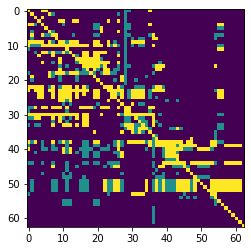

In [63]:
plt.imshow(new64_mat)

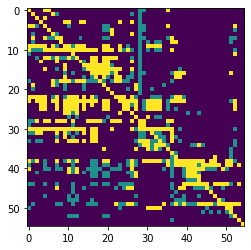

In [64]:
plt.imshow(IHS_mat)

In [65]:
columns = codes64
index = codes64
IHS_critical = pd.DataFrame(data = new64_mat, index=index, columns=columns)
IHS_critical.head()

,01,02,03,05-09,10-12,13-15,16,17,18,19,...,84,85,86,87-88,90-92,93,94,95,96,97-98
01,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05-09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-12,1.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
IHS_critical.to_csv('../../data/interim/economical/IHS_critical_NACE64.csv', index=True)

### Census 2011: Employees in every sector per arrondissement

NACE 21 classification

In [67]:
abs_dir = os.getcwd()
rel_dir = os.path.join(abs_dir, '../../data/raw/census_2011/census_arbeidsmarkt_nl_24oct14.xlsx')
df = pd.read_excel(rel_dir, sheet_name="Tabel3_2011")

In [68]:
codes=df['00.55 - Werkende bevolking van belgische en vreemde nationaliteit naar geslacht en economische sector'].loc[5:1943].dropna().values
codes_int = [int(i) for i in codes]

names = df.iloc[5:,1].dropna().values
rows=[]
for i in df['00.55 - Werkende bevolking van belgische en vreemde nationaliteit naar geslacht en economische sector'].loc[5:1943].dropna().index:
    intra_row = np.array([])
    intra_row = np.append(intra_row,df.iloc[i+2,3]) # A
    intra_row = np.append(intra_row,df.iloc[i+2,5:10]) # B, C, D, F
    intra_row = np.append(intra_row,df.iloc[i+2,11:17]) # G, H, I, J, K , L
    intra_row = np.append(intra_row,df.iloc[i+2,18:20]) # M, N
    intra_row = np.append(intra_row,df.iloc[i+2,21:24]) # O, P, Q
    intra_row = np.append(intra_row,df.iloc[i+2,25:29]) # R, S, T, U
    rows.append(intra_row)
matrix = np.zeros([len(rows),21])
for j in range(len(rows)):
    matrix[j,:]=rows[j]
    
economic_df=pd.DataFrame(matrix,index=codes_int,columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U'])
economic_df.index.name = 'NIS'
economic_df.head()

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,T,U
NIS,,,,,,,,,,,,,,,,,,,,,
1000,55652.0,2743.0,482836.0,20324.0,24645.0,266376.0,581650.0,216057.0,129482.0,105446.0,...,27106.0,198823.0,264768.0,489962.0,357202.0,484052.0,40374.0,104823.0,2409.0,1494.0
2000,37071.0,535.0,355465.0,12366.0,14671.0,177082.0,382641.0,141916.0,80931.0,69046.0,...,15954.0,130094.0,171561.0,272659.0,215344.0,302981.0,22828.0,62732.0,1749.0,473.0
3000,18351.0,2181.0,116827.0,6927.0,9280.0,80946.0,162882.0,61436.0,34701.0,24883.0,...,7499.0,48435.0,70643.0,181948.0,120586.0,152030.0,12869.0,32209.0,456.0,437.0
4000,230.0,27.0,10544.0,1031.0,694.0,8348.0,36127.0,12705.0,13850.0,11517.0,...,3653.0,20294.0,22564.0,35355.0,21272.0,29041.0,4677.0,9882.0,204.0,584.0
3001,943.0,6.0,3628.0,55.0,101.0,1976.0,3149.0,1137.0,688.0,283.0,...,64.0,685.0,653.0,2688.0,1817.0,2313.0,266.0,959.0,17.0,6.0


In [69]:
idx_arrondisement=[]
for idx in economic_df.index:
    if ((str(idx)[-3:] == '000') & (len(str(idx)) != 4) & (str(idx)[-4:] != '0000') & (str(idx)[0] != '0')):
        idx_arrondisement.append(idx)
print(idx_arrondisement)

[11000, 12000, 13000, 21000, 23000, 24000, 25000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 41000, 42000, 43000, 44000, 45000, 46000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 61000, 62000, 63000, 64000, 71000, 72000, 73000, 81000, 82000, 83000, 84000, 85000, 91000, 92000, 93000]


In [70]:
economic_df.loc[idx_arrondisement,:]

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,T,U
NIS,,,,,,,,,,,,,,,,,,,,,
11000,2136.0,45.0,42636.0,1652.0,1792.0,19828.0,58640.0,25502.0,13030.0,11336.0,...,2887.0,21430.0,29130.0,37390.0,29539.0,37708.0,4365.0,9771.0,294.0,53.0
12000,1482.0,17.0,20195.0,649.0,733.0,7818.0,21986.0,9143.0,3734.0,5095.0,...,664.0,7398.0,8843.0,12802.0,12145.0,14972.0,1253.0,3442.0,76.0,33.0
13000,3098.0,155.0,36550.0,562.0,1616.0,17240.0,24604.0,9392.0,5203.0,3341.0,...,765.0,7424.0,11017.0,16496.0,15491.0,19924.0,1438.0,3870.0,101.0,15.0
21000,230.0,27.0,10544.0,1031.0,694.0,8348.0,36127.0,12705.0,13850.0,11517.0,...,3653.0,20294.0,22564.0,35355.0,21272.0,29041.0,4677.0,9882.0,204.0,584.0
23000,1774.0,36.0,16911.0,1527.0,1218.0,10651.0,46140.0,14431.0,6976.0,9719.0,...,2011.0,17070.0,15198.0,29448.0,18577.0,23423.0,2251.0,6332.0,143.0,194.0
24000,2180.0,20.0,18975.0,813.0,1060.0,9639.0,28543.0,11619.0,5498.0,8903.0,...,1025.0,15156.0,12186.0,24051.0,20918.0,27865.0,1704.0,5290.0,141.0,72.0
25000,1479.0,74.0,10986.0,653.0,731.0,7068.0,22354.0,4861.0,4470.0,5676.0,...,1483.0,10822.0,8768.0,18428.0,14369.0,14636.0,1882.0,4027.0,99.0,97.0
31000,1861.0,4.0,13041.0,601.0,613.0,7743.0,16760.0,6201.0,6691.0,2219.0,...,1163.0,4846.0,7517.0,14309.0,9687.0,16311.0,1307.0,2990.0,93.0,5.0
32000,1542.0,1.0,3593.0,65.0,166.0,2406.0,3127.0,1038.0,592.0,247.0,...,86.0,635.0,1444.0,1855.0,1530.0,2993.0,141.0,459.0,33.0,0.0


In [71]:
economic_df.loc[idx_arrondisement,:].to_csv('../../data/interim/economical/census2011_NACE21.csv', index=True)

### Test function to load economic data and conversion matrices

In [72]:
from covid19model.data.economic_parameters import get_economic_parameters, get_conversion_matrix

In [73]:
pars = get_economic_parameters()

In [74]:
mat = get_conversion_matrix('WIOD55_NACE6')

ValueError: conversion matrix 'WIOD55_NACE6' not recognized 
valid arguments are: 'NACE21_NACE10', 'NACE38_NACE21', 'NACE64_NACE38', 'WIOD55_NACE64'

## ERMG Survey

### Employment

In [3]:
# inlezen
employment_df = pd.read_excel("../../data/raw/economical/ermg-tables.xlsx", sheet_name='Organisation of employees',index_col=[0], header=[0])

In [4]:
employment_df=employment_df.replace('NA4',0)
employment_df=employment_df.fillna(0)

In [5]:
from covid19model.data.economic_parameters import *
NACE64_labels = read_economic_labels('NACE64')

In [6]:
index = read_economic_labels('NACE64')
index = np.append(index,'Belgium')
df = pd.DataFrame(data=np.zeros([64,6]),columns=['temporarily unemployed','telework','mix telework/workplace','at workplace','sick leave','on leave'],index=index)
df.head()

,temporarily unemployed,telework,mix telework/workplace,at workplace,sick leave,on leave
01,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,0.0,0.0,0.0
03,0.0,0.0,0.0,0.0,0.0,0.0
05-09,0.0,0.0,0.0,0.0,0.0,0.0
10-12,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
date=list(reversed(['18.08.2020','23.06.2020','09.06.2020','26.05.2020','12.05.2020','05.05.2020','27.04.2020','20.04.2020','13.04.2020','06.04.2020']))
i_list=np.arange(len(date))*29
j=0

writer = pd.ExcelWriter('../../data/interim/economical/ERMG_employment_survey.xlsx')

for i in list(reversed(i_list)):
    
    # Sectors for which accurate data is available
    # --------------------------------------------

    # Accommodation and food service activities
    df.loc['55-56'] = employment_df.values[4+i,0:-2]
    # Agriculture and fishing
    df.loc['01'] = employment_df.values[5+i,0:-2]
    df.loc['02'] = employment_df.values[5+i,0:-2]
    df.loc['03'] = employment_df.values[5+i,0:-2]
    # Aviation
    df.loc['51'] = employment_df.values[6+i,0:-2]
    # Construction
    df.loc['41-43'] = employment_df.values[7+i,0:-2]
    # Engineering services
    df.loc['71'] = employment_df.values[9+i,0:-2]
    # Events and Recreation
    df.loc['90-92'] = employment_df.values[10+i,0:-2]
    df.loc['93'] = employment_df.values[10+i,0:-2]
    # Financial and insurance activities
    df.loc['64'] = employment_df.values[11+i,0:-2]
    df.loc['65'] = employment_df.values[11+i,0:-2]
    df.loc['66'] = employment_df.values[11+i,0:-2]
    # Human Resources
    df.loc['78'] = employment_df.values[12+i,0:-2]
    # Information and communication
    df.loc['58'] = employment_df.values[13+i,0:-2]
    df.loc['59-60'] = employment_df.values[13+i,0:-2]
    df.loc['61'] = employment_df.values[13+i,0:-2]
    df.loc['62-63'] = employment_df.values[13+i,0:-2]
    # Logistics
    df.loc['52'] = employment_df.values[15+i,0:-2] # Not correct yet
    # Manufacture of computer, electronic and optical products
    df.loc['26'] = employment_df.values[16+i,0:-2]
    # Manufacture of food products
    df.loc['10-12'] = employment_df.values[17+i,0:-2]
    # Manufacture of furniture
    df.loc['31-32'] = employment_df.values[18+i,0:-2]
    # Manufacture of machinery and electrical equipment
    df.loc['27'] = employment_df.values[19+i,0:-2]
    df.loc['28'] = employment_df.values[19+i,0:-2]
    # Manufacture of pharmaceutical and chemical products
    # Assumption: cokes and petroleum are very similar (chemical) industries
    df.loc['19'] = employment_df.values[20+i,0:-2]
    df.loc['20'] = employment_df.values[20+i,0:-2]
    df.loc['21'] = employment_df.values[20+i,0:-2]
    # Manufacture of plastic and non-metallic products
    df.loc['22'] = employment_df.values[21+i,0:-2]
    df.loc['23'] = employment_df.values[21+i,0:-2]
    # Manufacture of textiles, wearing apparel and shoes
    df.loc['13-15'] = employment_df.values[22+i,0:-2]
    # Manufacture of transport equipment
    df.loc['29'] = employment_df.values[23+i,0:-2]
    df.loc['30'] = employment_df.values[23+i,0:-2]
    # Manufacture of wood and paper products, and printing
    df.loc['16'] = employment_df.values[24+i,0:-2]
    df.loc['17'] = employment_df.values[24+i,0:-2]
    df.loc['18'] = employment_df.values[24+i,0:-2]
    # Metallurgy
    df.loc['24'] = employment_df.values[25+i,0:-2]
    df.loc['25'] = employment_df.values[25+i,0:-2]
    # Real estate activities
    df.loc['68'] = employment_df.values[26+i,0:-2]
    # Retail sales (food) + Retail sales (non-food)
    # http://imtb.actiris.be/Pages/SectImtDescription.aspx?secteur=221 --> food = 6% of retail
    df.loc['47'] = (0.06*employment_df.values[27+i,0:-2]+0.94*employment_df.values[28+i,0:-2])
    # Road transport (persons)
    # df.loc['49'] = employment_df.values[29,0:-2]
    # Wholesale
    df.loc['45'] = employment_df.values[30+i,0:-2]
    df.loc['46'] = employment_df.values[30+i,0:-2]

    # Data available from sectors with high similarity
    # ------------------------------------------------

    # Land and water transport --> set to air transport
    # = most reliable since air transport consists of freight + persons
    df.loc['49'] = employment_df.values[6+i,0:-2]
    df.loc['50'] = employment_df.values[6+i,0:-2]

    # Average of all industrial 'sectors'
    df.loc['05-09'] = np.mean(employment_df.values[16+i:25+i,0:-2],axis=0)
    df.loc['33'] = np.mean(employment_df.values[16+i:25+i,0:-2],axis=0)
    df.loc['35'] = np.mean(employment_df.values[16+i:25+i,0:-2],axis=0)
    df.loc['36'] = np.mean(employment_df.values[16+i:25+i,0:-2],axis=0)
    df.loc['37-39'] = np.mean(employment_df.values[16+i:25+i,0:-2],axis=0)

    # Legal and accounting services = Financial service activities (K)
    df.loc['69-70'] = employment_df.values[11+i,0:-2]

    # All missing from M and N --> average of Engineering, HR, Consultancy and Liberal professions
    # which are in same aggregation in survey
    df.loc['72'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4
    df.loc['73'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4
    df.loc['74-75'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4
    df.loc['77'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4
    df.loc['78'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4
    df.loc['79'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4
    df.loc['80-82'] = (employment_df.values[8+i,0:-2] + employment_df.values[9+i,0:-2] + employment_df.values[12+i,0:-2] + employment_df.values[14+i,0:-2])/4

    # Public administration and defence, education:
    # 100 % telework and no temporary unemployment
    df.loc['84'] = [0, 100, 0, 0, 0, 0 ]
    df.loc['85'] = [0, 100, 0, 0, 0, 0 ]

    # Postal services and couriers
    # I could still order shit during lockdown so I guess everyone worked in this sector
    df.loc['53'] = [0, 0, 0, 100, 0, 0 ]

    # Belgian average (if no data available)
    # --------------------------------------

    # Sector Q (social work, human health)
    df.loc['86'] = employment_df.values[31+i,0:-2]
    df.loc['87-88'] = employment_df.values[31+i,0:-2]

    # Sector S (personal service)
    df.loc['94'] = employment_df.values[31+i,0:-2]
    df.loc['95'] = employment_df.values[31+i,0:-2]
    df.loc['96'] = employment_df.values[31+i,0:-2]

    # Sector T
    df.loc['97-98'] = employment_df.values[31+i,0:-2]
    
    # Belgium
    df.loc['Belgium'] = employment_df.values[31+i,0:-2]
    
    df.to_excel(writer, sheet_name=date[j])
    writer.save()
        
    j=j+1    

### Revenue survey

In [8]:
# inlezen
revenue_df = pd.read_excel("../../data/raw/economical/ermg-tables.xlsx", sheet_name='Revenue impact',index_col=[0], header=[0])

In [9]:
revenue_df.values[4,0:-2]

array([-93.17091616248919, -82.95427196149217, -88.06427662282563,
       -95.3767123287671, -84.25971622455268, -86.6987951807229,
       -93.29252003561888, -84.91618497109828, -74.74594213126329,
       -50.2937538651825, -42.463212752912334], dtype=object)

In [10]:
index = read_economic_labels('NACE64')
index = np.append(index,'Belgium')
date=['2020-08-18','2020-06-23','2020-06-09','2020-05-26','2020-05-12','2020-05-05','2020-04-27','2020-04-20','2020-04-13','2020-04-06','2020-03-30']
df = pd.DataFrame(data=np.zeros([64,11]),columns=list(reversed(date)),index=index)
df.head()

,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-05,2020-05-12,2020-05-26,2020-06-09,2020-06-23,2020-08-18
01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
employment_df = revenue_df
i=0

# Sectors for which accurate data is available
# --------------------------------------------

# Accommodation and food service activities
df.loc['55-56'] = employment_df.values[4+i,0:-2]
# Agriculture and fishing
df.loc['01'] = employment_df.values[5+i,0:-2]
df.loc['02'] = employment_df.values[5+i,0:-2]
df.loc['03'] = employment_df.values[5+i,0:-2]
# Aviation
df.loc['51'] = employment_df.values[6+i,0:-2]
# Construction
df.loc['41-43'] = employment_df.values[7+i,0:-2]
# Engineering services
df.loc['71'] = employment_df.values[9+i,0:-2]
# Events and Recreation
df.loc['90-92'] = employment_df.values[10+i,0:-2]
df.loc['93'] = employment_df.values[10+i,0:-2]
# Financial and insurance activities
df.loc['64'] = employment_df.values[11+i,0:-2]
df.loc['65'] = employment_df.values[11+i,0:-2]
df.loc['66'] = employment_df.values[11+i,0:-2]
# Human Resources
df.loc['78'] = employment_df.values[12+i,0:-2]
# Information and communication
df.loc['58'] = employment_df.values[13+i,0:-2]
df.loc['59-60'] = employment_df.values[13+i,0:-2]
df.loc['61'] = employment_df.values[13+i,0:-2]
df.loc['62-63'] = employment_df.values[13+i,0:-2]
# Logistics
df.loc['52'] = employment_df.values[15+i,0:-2] # Not correct yet
# Manufacture of computer, electronic and optical products
df.loc['26'] = employment_df.values[16+i,0:-2]
# Manufacture of food products
df.loc['10-12'] = employment_df.values[17+i,0:-2]
# Manufacture of furniture
df.loc['31-32'] = employment_df.values[18+i,0:-2]
# Manufacture of machinery and electrical equipment
df.loc['27'] = employment_df.values[19+i,0:-2]
df.loc['28'] = employment_df.values[19+i,0:-2]
# Manufacture of pharmaceutical and chemical products
# Assumption: cokes and petroleum are very similar (chemical) industries
df.loc['19'] = employment_df.values[20+i,0:-2]
df.loc['20'] = employment_df.values[20+i,0:-2]
df.loc['21'] = employment_df.values[20+i,0:-2]
# Manufacture of plastic and non-metallic products
df.loc['22'] = employment_df.values[21+i,0:-2]
df.loc['23'] = employment_df.values[21+i,0:-2]
# Manufacture of textiles, wearing apparel and shoes
df.loc['13-15'] = employment_df.values[22+i,0:-2]
# Manufacture of transport equipment
df.loc['29'] = employment_df.values[23+i,0:-2]
df.loc['30'] = employment_df.values[23+i,0:-2]
# Manufacture of wood and paper products, and printing
df.loc['16'] = employment_df.values[24+i,0:-2]
df.loc['17'] = employment_df.values[24+i,0:-2]
df.loc['18'] = employment_df.values[24+i,0:-2]
# Metallurgy
df.loc['24'] = employment_df.values[25+i,0:-2]
df.loc['25'] = employment_df.values[25+i,0:-2]
# Real estate activities
df.loc['68'] = employment_df.values[26+i,0:-2]
# Retail sales (food) + Retail sales (non-food)
# http://imtb.actiris.be/Pages/SectImtDescription.aspx?secteur=221 --> food = 6% of retail
df.loc['47'] = (0.06*employment_df.values[27+i,0:-2]+0.94*employment_df.values[28+i,0:-2])
# Road transport (persons)
# df.loc['49'] = employment_df.values[29,0:-2]
# Wholesale
df.loc['45'] = employment_df.values[30+i,0:-2]
df.loc['46'] = employment_df.values[30+i,0:-2]

# Belgium
df.loc['Belgium'] = employment_df.values[31+i,0:-2]

In [36]:
df.head()

,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-05,2020-05-12,2020-05-26,2020-06-09,2020-06-23,2020-08-18
01,-34.139093,-22.870791,-10.642458,0.695021,-3.465517,-32.705906,0.060484,-16.591365,-3.859517,-18.940678,-2.412587
02,-34.139093,-22.870791,-10.642458,0.695021,-3.465517,-32.705906,0.060484,-16.591365,-3.859517,-18.940678,-2.412587
03,-34.139093,-22.870791,-10.642458,0.695021,-3.465517,-32.705906,0.060484,-16.591365,-3.859517,-18.940678,-2.412587
05-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10-12,-13.503535,-17.095536,-24.353453,-20.427186,-15.292420,-21.109988,-17.008545,-22.311879,-20.698438,-11.909063,-8.028691


In [37]:
import datetime

In [38]:
print(df.columns)
datetime_dates=[datetime.datetime.strptime(date,"%Y-%m-%d") for date in df.columns]

Index(['2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20', '2020-04-27',
       '2020-05-05', '2020-05-12', '2020-05-26', '2020-06-09', '2020-06-23',
       '2020-08-18'],
      dtype='object')


In [39]:
employment_df=pd.read

AttributeError: module 'pandas' has no attribute 'read'

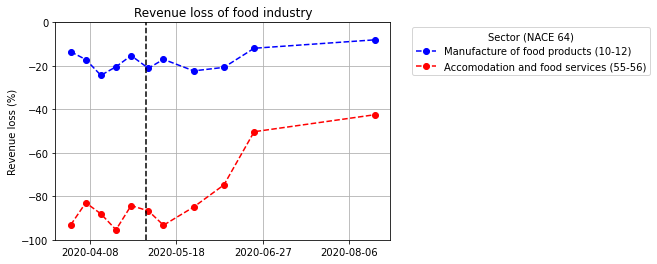

In [40]:
# Manufacture of food products

fig,ax = plt.subplots()

ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')
ax.plot(datetime_dates,df.loc['55-56'],color='red',ls='--',marker='o')

ax.set_ylim([-100,0])
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.axvline(datetime.datetime.strptime('2020-05-04',"%Y-%m-%d"),color='black',ls='--')
ax.set_ylabel('Revenue loss (%)')
ax.set_title('Revenue loss of food industry')
ax.legend(['Manufacture of food products (10-12)', 'Accomodation and food services (55-56)'], title='Sector (NACE 64)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')

In [41]:
writer = pd.ExcelWriter('../../data/interim/economical/ERMG_revenue_survey.xlsx')
df.to_excel(writer, sheet_name=date[j])
writer.save()